In [1]:
from fastai import *
from fastai.collab import *

## Collaborative filtering example
collab models use data in a DataFrame of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

WindowsPath('C:/Users/Tim/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [5]:
series2cat(ratings, 'userId', 'movieId')

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [7]:
data = CollabDataBunch.from_df(ratings)

In [11]:
data

TabularDataBunch;

Train: LabelList (4825 items)
x: CollabList
userId 73; movieId 1097; ,userId 561; movieId 924; ,userId 157; movieId 260; ,userId 358; movieId 1210; ,userId 130; movieId 316; 
y: FloatList
4.0,3.5,3.5,5.0,2.0
Path: .;

Valid: LabelList (1206 items)
x: CollabList
userId 402; movieId 2762; ,userId 157; movieId 3793; ,userId 346; movieId 480; ,userId 430; movieId 1; ,userId 95; movieId 2858; 
y: FloatList
3.0,3.5,1.0,4.0,5.0
Path: .;

Test: None

In [12]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.))

In [13]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,2.438756,1.957460,00:56
1,1.135377,0.718904,00:52
2,0.726273,0.683151,00:54
3,0.624960,0.670122,00:54
4,0.569884,0.667168,01:15


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [8]:
path=Config.data_path()/'ml-100k'
path

WindowsPath('C:/Users/Tim/.fastai/data/ml-100k')

In [9]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
len(ratings)

100000

In [12]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [13]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [14]:
data.show_batch()

userId,title,target
77,"Clockwork Orange, A (1971)",5.0
128,Muriel's Wedding (1994),3.0
213,Annie Hall (1977),5.0
747,Secrets & Lies (1996),5.0
622,Under Siege 2: Dark Territory (1995),1.0


In [15]:
y_range = [0,5.5]

n_factors (latent factors) is explained in lesson5 in details, and why 40 also explained there.

In [16]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


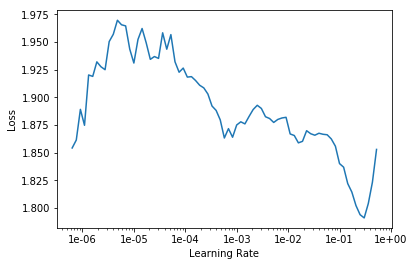

In [17]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,time
0,0.931651,0.947713,01:10
1,0.883105,0.897079,01:07
2,0.764714,0.841536,01:13
3,0.650626,0.818404,01:09
4,0.552552,0.815828,01:04


In [19]:
learn.save('dotprod')

Here's some benchmarks on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of 0.91**2 = 0.83.

## Interpretation

### Setup

In [20]:
learn.load('dotprod');

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [22]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [23]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [35]:
movie_bias

tensor([ 5.2786e-01,  3.9474e-01,  4.0586e-01,  3.6429e-01,  7.5967e-02,
         1.2456e-01,  1.9944e-01,  3.0033e-01,  2.8381e-01,  1.4592e-01,
         4.4324e-01,  4.8200e-01,  3.2088e-01,  2.7902e-01,  5.4044e-01,
         2.0440e-01,  1.6099e-01,  2.4740e-01,  3.7886e-01,  2.2671e-01,
         2.5041e-01,  5.6639e-01,  1.2881e-01,  4.0219e-01,  3.4727e-01,
         1.2152e-01,  3.5344e-01,  2.3642e-01,  3.0698e-01,  4.2481e-02,
         3.9113e-01,  2.5932e-01,  3.4428e-01,  2.0433e-01,  2.6202e-01,
         5.9336e-01,  1.4471e-01,  3.3478e-01,  5.1786e-01,  3.7254e-01,
         1.9052e-01,  2.3626e-01,  1.1795e-01,  3.2414e-02,  3.6231e-01,
         2.6369e-01,  2.6939e-01,  5.7060e-01,  2.2049e-01,  1.9551e-01,
         3.5121e-01,  3.5367e-01,  4.2504e-01,  1.3766e-01,  3.0263e-01,
         2.6833e-01,  4.6199e-01,  4.4487e-01,  2.1380e-01,  1.8342e-01,
        -4.4550e-02,  1.9448e-01,  2.5224e-01, -4.6133e-02,  2.4038e-01,
         1.5293e-01,  3.1875e-01,  2.6788e-01,  2.1

In [24]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [26]:
movie_ratings

[(tensor(0.5279), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.3947), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.4059), 'Fargo (1996)', 4.155511811023622),
 (tensor(0.3643), 'Return of the Jedi (1983)', 4.007889546351085),
 (tensor(0.0760), 'Liar Liar (1997)', 3.156701030927835),
 (tensor(0.1246), 'English Patient, The (1996)', 3.656964656964657),
 (tensor(0.1994), 'Scream (1996)', 3.4414225941422596),
 (tensor(0.3003), 'Toy Story (1995)', 3.8783185840707963),
 (tensor(0.2838), 'Air Force One (1997)', 3.6310904872389793),
 (tensor(0.1459), 'Independence Day (ID4) (1996)', 3.438228438228438),
 (tensor(0.4432), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4820), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.3209), 'Pulp Fiction (1994)', 4.060913705583756),
 (tensor(0.2790), 'Twelve Monkeys (1995)', 3.798469387755102),
 (tensor(0.5404), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.2044), 'Jerry Maguire (1996)', 3.7109375),
 

In [27]:
item0 = lambda o:o[0]

In [28]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3600),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3091),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2645), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2589), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2585), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2428), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2364), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2351), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2343), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2329), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2290), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2280), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2261), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2247), 'Leave It to Beaver (1997)', 1.84090909090909

In [29]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5934), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5706), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5664), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5441), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5404), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5279), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5265), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5179), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4929), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4820), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4819), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4678), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4650), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4620), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4567), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

### Movie weights

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [37]:
movie_w

tensor([[ 0.0765, -0.5227, -0.4876,  ..., -0.5731,  0.4589,  0.3970],
        [ 0.0857, -0.1949, -0.2200,  ..., -0.3140,  0.3401,  0.1211],
        [-0.0063, -0.1861, -0.2092,  ..., -0.0619, -0.0143,  0.1856],
        ...,
        [ 0.1782,  0.0361,  0.1045,  ...,  0.0812, -0.0458, -0.1008],
        [ 0.0859,  0.0614, -0.0034,  ...,  0.0684, -0.0859, -0.1037],
        [-0.0089,  0.0507, -0.0233,  ..., -0.0897,  0.1224, -0.0208]])

In [31]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [36]:
movie_pca

tensor([[ 0.6166, -0.8202, -0.7488],
        [ 0.0805, -0.3579,  0.1166],
        [ 0.8026,  0.2108,  0.0206],
        ...,
        [-0.2584,  0.4148,  0.0386],
        [-0.6921,  0.3751,  0.0392],
        [-0.6029, -0.1461,  0.0223]])

In [32]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1609), 'Wrong Trousers, The (1993)'),
 (tensor(1.0939), 'Close Shave, A (1995)'),
 (tensor(1.0672), 'Chinatown (1974)'),
 (tensor(1.0242), 'Casablanca (1942)'),
 (tensor(1.0237), 'Lawrence of Arabia (1962)'),
 (tensor(1.0005), 'When We Were Kings (1996)'),
 (tensor(0.9725), 'Third Man, The (1949)'),
 (tensor(0.9523),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9441), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9361), 'Citizen Kane (1941)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2516), "McHale's Navy (1997)"),
 (tensor(-1.2370), 'Jungle2Jungle (1997)'),
 (tensor(-1.1909), 'Home Alone 3 (1997)'),
 (tensor(-1.1304), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1301), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1204), 'Congo (1995)'),
 (tensor(-1.1175), 'Grease 2 (1982)'),
 (tensor(-1.0930), 'Flipper (1996)'),
 (tensor(-1.0784), 'Bio-Dome (1996)'),
 (tensor(-1.0721), 'Leave It to Beaver (1997)')]

In [38]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [39]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9074), 'Keys to Tulsa (1997)'),
 (tensor(0.8749), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8088), 'Road to Wellville, The (1994)'),
 (tensor(0.7931), 'Brazil (1985)'),
 (tensor(0.7928), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7871), 'Heavenly Creatures (1994)'),
 (tensor(0.7806), 'Clockwork Orange, A (1971)'),
 (tensor(0.7666), 'Trainspotting (1996)'),
 (tensor(0.7559), 'Sweet Hereafter, The (1997)'),
 (tensor(0.7477), 'Dead Man (1995)')]

In [40]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2096), 'Braveheart (1995)'),
 (tensor(-1.1267), 'Titanic (1997)'),
 (tensor(-1.1115), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9190), "It's a Wonderful Life (1946)"),
 (tensor(-0.8649), 'American President, The (1995)'),
 (tensor(-0.8534), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8408), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8343), 'Field of Dreams (1989)'),
 (tensor(-0.8266), 'Air Force One (1997)'),
 (tensor(-0.8257), 'Hunt for Red October, The (1990)')]

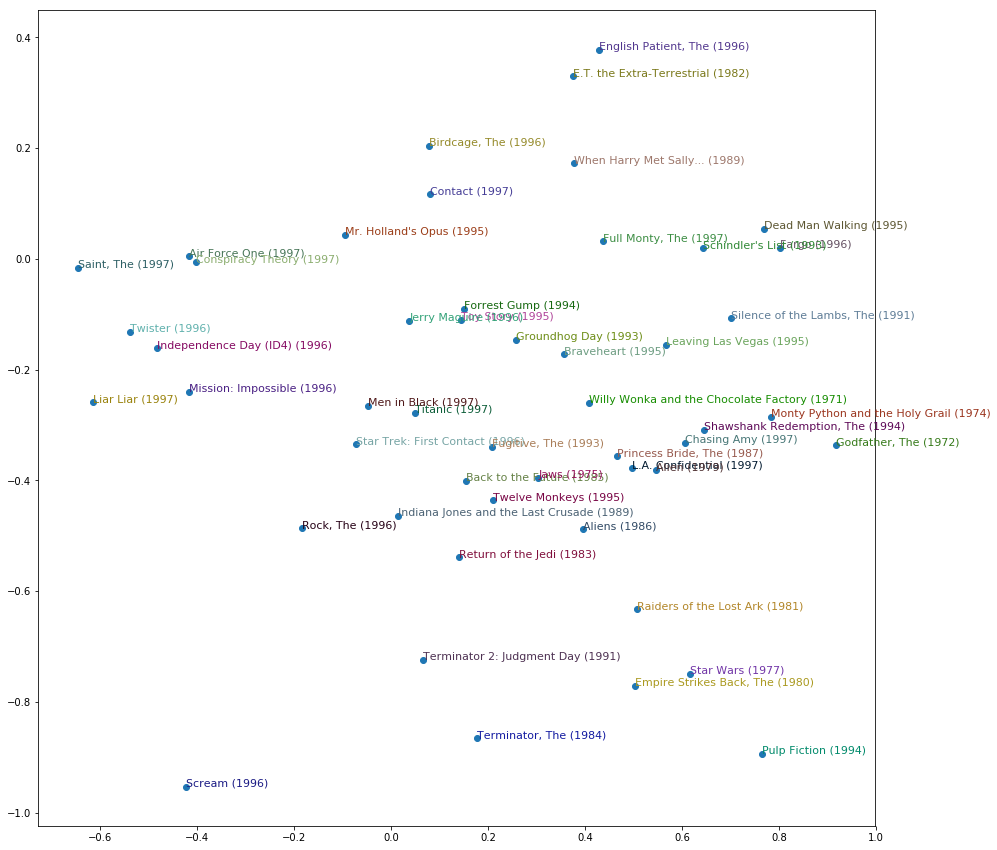

In [41]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [42]:
X

tensor([ 0.6166,  0.0805,  0.8026,  0.1410, -0.6139,  0.4293, -0.4221,  0.1445,
        -0.4155, -0.4830,  0.5084,  0.9170,  0.7653,  0.2097,  0.7013,  0.0380,
         0.6072, -0.1822,  0.5029, -0.0719,  0.1558,  0.0506, -0.4171,  0.2094,
         0.0138,  0.4094,  0.4661,  0.1513,  0.7829, -0.6445,  0.4371, -0.0473,
         0.1773,  0.3757,  0.7697,  0.6432,  0.5682,  0.3564,  0.4967,  0.0663,
        -0.4014, -0.0940,  0.0781, -0.5372,  0.5467,  0.3783,  0.3960,  0.6454,
         0.2577,  0.3042])

In [43]:
Y

tensor([-0.7488,  0.1166,  0.0206, -0.5389, -0.2585,  0.3782, -0.9530, -0.1099,
         0.0052, -0.1613, -0.6319, -0.3368, -0.8931, -0.4361, -0.1065, -0.1124,
        -0.3317, -0.4867, -0.7707, -0.3347, -0.4002, -0.2776, -0.2403, -0.3397,
        -0.4634, -0.2593, -0.3559, -0.0907, -0.2852, -0.0155,  0.0319, -0.2648,
        -0.8648,  0.3306,  0.0538,  0.0196, -0.1555, -0.1714, -0.3780, -0.7235,
        -0.0064,  0.0428,  0.2037, -0.1314, -0.3814,  0.1726, -0.4872, -0.3083,
        -0.1465, -0.3957])

## Collab filtering from scratch

### Dot product example

In [47]:
a = Tensor([[1.,2],[3,4]])
b = Tensor([[2.,2],[10,10]])
a,b

(tensor([[1., 2.],
         [3., 4.]]), tensor([[ 2.,  2.],
         [10., 10.]]))

In [48]:
a*b

tensor([[ 2.,  4.],
        [30., 40.]])

In [49]:
(a*b).sum(1)

tensor([ 6., 70.])

In [50]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [51]:
model = DotProduct()

In [52]:
model(a,b)

tensor([ 6., 70.])

### Dot product model

In [53]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [54]:
n_users, n_movies

(943, 1682)

In [55]:
u_uniq

array([196, 186,  22, 244, ..., 936, 930, 920, 941], dtype=int64)

In [58]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [59]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [60]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

NameError: name 'ColumnarModelData' is not defined